# Deep learning models for sentiment analysis.


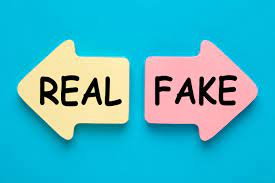

the goal of this notebook is to show several deep learning methods to solve the Disaster Tweets challenge. I'm going to start by presenting the data that we're going to study. Then I will present four deep learning models built using pytorch. To finally use these four models in a single prediction. The  models will be created with pytorch.



### Table of Contents

* <a href="#Presentation of data.">Presentation of data.</a>
* <a href="#LSTM Clasifier">LSTM Clasifier</a>
* <a href="#Fine tuning BERT">Fine tuning BERT</a>
* <a href="#Fine tuning XLNET">Fine tuning XLNET</a>
* <a href="#Model comparison.">Model comparison.</a>

### Indications before running the notebook.

* You will only be able to run this notebook if you have a GPU, so if your computer does not have one you can go to Google Colaboratory to get access to a GPU. In the code below I assume that you have your notebook on google colaboratory and that you have modified the type of execution to activate a GPU. If so, you should see "Device: cuda" as a message.
* Also I assume you have downloaded dataset locally. If this is the case you will need to modify ```path_data``` so that it indicates the position of the data.



In [ ]:
colab=False
import torch
if colab:
    from google.colab import drive
    

    drive.mount('/content/drive')
    path_data_test="/content/drive/My Drive/IPP-M2-DS/Deep with python/Sentiment Analysis/Data/test.csv"
    path_data_train="/content/drive/My Drive/IPP-M2-DS/Deep with python/Sentiment Analysis/Data/train.csv"
    path_data_sub = "/content/drive/My Drive/IPP-M2-DS/Deep with python/Sentiment Analysis/Data/sample_submission.csv"
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print("Device :",device)
    
else :
    path_data_test="../input/nlp-getting-started/test.csv"
    path_data_train="../input/nlp-getting-started/train.csv"
    path_data_sub = "../input/nlp-getting-started/sample_submission.csv"
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print("Device :",device)

concerning the packages you will have to install two packages on google colaboratory with the following commands:

In [ ]:
#!pip install transformers
#!pip install datasets

import os
from tqdm import tqdm, trange
import random
import time
import pickle
from sklearn.metrics import f1_score   


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd
import math
import time
import pprint
pp = pprint.PrettyPrinter()
import numpy as np
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
from torchtext.legacy import data
from torchtext.data.utils import get_tokenizer

import torch.nn as nn

from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, get_scheduler
from transformers import XLNetConfig,AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
from datasets import Dataset, load_dataset, load_metric
from sklearn.metrics import f1_score
from keras.preprocessing.sequence import pad_sequences


results={}
models_name = ["BERTA","BERT","XLNET","LSTM"]
for model_name in models_name:
  results[model_name] = {"Train Loss":[],"Train Acc":[],"Train f1":[],
                         "Val. Loss": [],"Val. Acc":[],"Val. f1":[],
                         "test. Acc":0,"test. loss":0,"test. f1":0,
                         "Training time":0}



The results dictionary will allow you to store the results as the experiments progress.


<a id="Functions"></a>
# Functions

During this notebook we will use 3 main functions. One for model training (```train```). One for validation (```evaluate```) and finally one to visualize the performance (```plot_results```) of our models. Note that the train and validation function takes the model you want to train as an argument. We do this because the 4 models do not have exactly the same types of arguments for training and they do not use the same dataloader.


In [ ]:
def train(model,iterator,optimizer,criterion,train_LSTM=False,train_pretrain=False):
  torch.cuda.empty_cache()
  epoch_loss = 0.0
  epoch_acc = 0.0
  epoch_f1 = 0.0

  model.train()
  metric = load_metric("accuracy")
  metric2 = load_metric("f1")
  for batch in iterator:
      optimizer.zero_grad()

      if train_LSTM:

        text,text_lengths = batch.text
        predictions = model(text,text_lengths).squeeze()
        loss = criterion(predictions,batch.target)

        correct = (torch.round(predictions) == batch.target).float() 
        acc = correct.sum() / len(correct)

        y_true= batch.target.cpu().detach().numpy()
        predictions = torch.round(predictions).cpu().detach().numpy()
        f1 = f1_score(y_true, predictions)
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_f1 += f1

        loss.backward()
        optimizer.step()





      if train_pretrain:

        b_input_ids = batch["input_ids"].to(device)
        b_input_mask = batch["attention_mask"].to(device)
        b_labels = batch["target"].to(device)        
        outputs = model(b_input_ids,token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        predictions = outputs.logits
        predictions = torch.argmax(predictions, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["target"])
        metric2.add_batch(predictions=predictions, references=batch["target"])
        epoch_loss += loss.cpu().detach().numpy()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()

  if  train_pretrain:
     return epoch_loss / len(iterator), metric.compute()["accuracy"], metric2.compute()["f1"]

  if not train_pretrain:
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1 / len(iterator)

def evaluate(model,iterator,criterion, train_LSTM=False,train_pretrain=False):

    epoch_loss = 0.0
    epoch_acc = 0.0
    epoch_f1 = 0.0
    
    # deactivate the dropouts
    model.eval()
    metric = load_metric("accuracy")
    metric2 = load_metric("f1")
    # Sets require_grad flat False
    with torch.no_grad():
        for batch in iterator:
            if train_LSTM:

              text,text_lengths = batch.text
              predictions = model(text,text_lengths).squeeze()
              loss = criterion(predictions,batch.target)

              correct = (torch.round(predictions) == batch.target).float() 
              acc = correct.sum() / len(correct)

              y_true= batch.target.cpu().detach().numpy()
              predictions = torch.round(predictions).cpu().detach().numpy()
              f1 = f1_score(y_true, predictions)

              epoch_loss += loss.item()
              epoch_acc += acc.item()
              epoch_f1 +=f1.item()


            if train_pretrain:
              
              b_input_ids = batch["input_ids"].to(device)
              b_input_mask = batch["attention_mask"].to(device)
              b_labels = batch["target"].to(device)        
              outputs = model(b_input_ids,token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
              
              loss = outputs.loss
              predictions = outputs.logits
              predictions = torch.argmax(predictions, dim=-1)
              lr_scheduler.step()
              metric.add_batch(predictions=predictions, references=batch["target"])
              metric2.add_batch(predictions=predictions, references=batch["target"])
              epoch_loss += loss.cpu().detach().numpy()

    if  train_pretrain:
      return epoch_loss / len(iterator), metric.compute()["accuracy"], metric2.compute()["f1"]
    if not train_pretrain:
      return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1 / len(iterator)


def test(model,iterator,criterion, train_LSTM=False,train_pretrain=False):    
    preds = []
    idss = []
    probas = []
    with torch.no_grad():
        for batch in iterator:
            if train_LSTM:
              text,text_lengths = batch.text
              idss+= [int(i) for i in batch.id]
              out = model(text,text_lengths)
              preds+= torch.round(out).reshape(-1).int().tolist()
              probas+= out.reshape(-1).tolist()
             
            if train_pretrain:
              b_input_ids = batch["input_ids"].to(device)
              b_input_mask = batch["attention_mask"].to(device)
              outputs = model(b_input_ids,token_type_ids=None, 
                                  attention_mask=b_input_mask)
              predictions = outputs.logits
              idss+=[int(i) for i in batch["id"]]
              preds += torch.argmax(predictions, dim=-1).cpu().reshape(-1).int().tolist()
                
              predictions=predictions-predictions.min()
              predictions = predictions[:,1]/predictions.sum(axis=1)
              probas+= predictions.cpu().reshape(-1).tolist()
            
            
        
        mapp=dict(zip(idss,preds))
        mapp2=dict(zip(idss,probas))
        pred=pd.read_csv(path_data_sub)
        pred["target"]=pred["id"].map(mapp)
        pred2 = pred.copy()
        pred2["probas"]=pred2["id"].map(mapp2)
        return pred,pred2

In [ ]:
def plot_results(model_name):
  plt.style.use("seaborn")
  fig, (ax1,ax2,ax3) = plt.subplots(3,sharex=True)
  ax1.set_title(model_name,fontsize=18,fontstyle='italic')

  ax1.plot(results[model_name]["Train Acc"],label="Train Acc",linewidth=3)
  ax1.plot(results[model_name]["Val. Acc"],label="Val. Acc",linewidth=3)
  ax1.legend(loc='upper left', shadow=True)
  ax1.set_xlabel('EPOCHS')
  ax1.set_ylabel('Accuracy')

  ax3.plot(results[model_name]["Train Loss"],label="Train Loss",linewidth=3)
  ax3.plot(results[model_name]["Val. Loss"],label="Val. Loss",linewidth=3)
  ax3.legend(loc='upper left', shadow=True)
  ax3.set_xlabel('EPOCHS')
  ax3.set_ylabel('Loss')

  ax2.plot(results[model_name]["Train f1"],label="Train f1",linewidth=3)
  ax2.plot(results[model_name]["Val. f1"],label="Val. f1",linewidth=3)
  ax2.legend(loc='upper left', shadow=True)
  ax2.set_xlabel('EPOCHS')
  ax2.set_ylabel('f1')

  fig.set_figheight(12.3)
  fig.set_figwidth(10)


# Presentation of data.


In [ ]:
df = pd.read_csv(path_data_train)
df.head()

In [ ]:
pp.pprint(df.loc[0]["text"])
print("target :",df.loc[0]["target"])

We have the same number of positive and negative reviews, a balanced dataset. We can use the accuracy to compare our results.


In [ ]:
X = df.text
y = df.target

fig = plt.figure(figsize=(5,5))
colors=["#1F77B4",'#A87AD4']
pos=y[y == 1]
neg=y[y == 0]
ck=[pos.count(),neg.count()]
legpie=plt.pie(ck,labels=["Positive","Negative"],
                 autopct ='%1.1f%%', 
                 shadow = True,
                 colors = colors,
                 startangle = 45,
                 explode=(0, 0.1))
plt.title("Propotion of negative and positive reviews")
plt.show()

In [ ]:
sns.displot(df["text"].apply(lambda x : len(x.split(' '))).tolist())

In [ ]:
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)
ID = data.RawField()
fields = [("id",ID),(None,None),(None,None),('text',TEXT),("target",LABEL)]
training_data = data.TabularDataset(path=path_data_train,
                                    format="csv",
                                    fields=fields,
                                    skip_header=True
                                   )
train_data,valid_data = training_data.split(split_ratio=0.8)
test_data = data.TabularDataset(path=path_data_test,
                                    format="csv",
                                    fields=[("id",ID),(None,None),(None,None),('text',TEXT)],
                                    skip_header=True
                                   )

In [ ]:
TEXT.build_vocab(train_data,min_freq=2)
LABEL.build_vocab(train_data)
BATCH_SIZE = 32
train_iterator = data.BucketIterator(
        dataset=train_data,
        batch_size=BATCH_SIZE,
        repeat=False,
        sort=False,
        device = device)

test_iterator = data.BucketIterator(
        dataset=test_data,
        batch_size=BATCH_SIZE,
        repeat=False,
        sort=False,
        device = device)

validation_iterator = data.BucketIterator(
        dataset=valid_data,
        batch_size=BATCH_SIZE,
        repeat=False,
        sort=False,
        device = device)
print("Train size = {}, Test size = {}, valid size = {}".format(len(train_data),len(test_data),len(valid_data)))

# LSTM CLASSIFIER

We will start from a randomly initialized embedding that we will train. We will also use a bidirectional LSTM. The second layer use the pack_padded_sequence function. without going into too much detail, the idea of ​​this function is to save calculation time but will not influence the result. As you can see this model uses an LSTM layer.


 With pytorch the lstm layer returns a lot of information to us, it is not always easy to see clearly which one to use. As a reminder, one of the problems with RNNs comes from gradient backpropagation. When the chain is too large, the gradient tends either to explode or to disappear, which makes learning long-term relationships very complicated for this type of model. Hence the interest of using an LSTM. The LSTM will solve this problem by having a long-term memory. Thus LSTM receives three sources of information at the input of each cell, the data, the short-term memory which is recorded in the hidden states and the long-term memory which is recorded in the cell states. The LSTM cell will also return three items.

* output : which is composed of all the hidden states in the last layer.
* hidden : hidden state which contains information about the previous time step.
* Cell : cell which contains information about all previous information in the sentence.



We will also use a bidirectional LSTM. The idea is that we will pass the data in one direction but also in the other. Thus we will use the information contained in the past and the future to predict the words. By having a bidirectional LSTM we will therefore have two hidden states. One for the forward part and the other for the backward part of the LSTM (nothing to do with the gradient here). We will retrieve the last hidden states from the forward and backward part that we will concatenate before using it as features in a fully connected layer.









In [ ]:

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(),batch_first=True,enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        dense_outputs=self.fc(hidden)
        outputs=self.act(dense_outputs)
        return outputs

In [ ]:
model = classifier (vocab_size=len(TEXT.vocab),
                    embedding_dim=100,
                    hidden_dim=63,
                    output_dim=1,
                    n_layers=2,
                    bidirectional=True,
                    dropout=0.2).to(device)
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-4)

In [ ]:
start =time.time()
EPOCH_NUMBER=12
for epoch in range(1,EPOCH_NUMBER+1):
    print(f"\t Epoch: {epoch}")
    train_loss,train_acc,train_f1 = train(model,train_iterator,optimizer,criterion,train_LSTM=True)
    valid_loss,valid_acc,valid_f1  = evaluate(model,validation_iterator,criterion,train_LSTM=True)
  
    results["LSTM"]["Train Loss"].append(train_loss)
    results["LSTM"]["Train Acc"].append(train_acc*100)
    results["LSTM"]["Train f1"].append(train_f1*100)

    results["LSTM"]["Val. Loss"].append(valid_loss)
    results["LSTM"]["Val. Acc"].append(valid_acc*100)
    results["LSTM"]["Val. f1"].append(valid_f1*100)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f} | Train f1: {train_f1*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f} |  val. f1: {valid_f1*100:.2f}%')
    print()

In [ ]:
pred_LSTM, probas_LSTM = test(model,test_iterator,criterion,train_LSTM=True)

In [ ]:
plot_results("LSTM")

# Fine tuning

We will now fine tune transformers models. We are going to look at two more complex models now and see if their use really makes sense in the case of a dataset like Dataset. During this part on fine tuning we will focus on two well-known models [BERT](https://arxiv.org/pdf/1810.04805.pdf) and [XLNET](https://arxiv.org/pdf/1906.08237.pdf). To fine tune these models we will use the very practical "transformers" library of [hugging face](https://huggingface.co/). 




I'll start by quickly explaining what a transformer is. Transformers were proposed in 2017 in this [paper](https://arxiv.org/pdf/1706.03762.pdf), and have since been state-of-the-art in NLP.  In addition, the great progress of these models is that it will take the entire sentence as input and no longer sequentially as before. This will greatly improve computation times. 




In [ ]:
model_max_length=50
batch_size=32
EPOCH_NUMBER=8

# XLNET

In the family of transformers there are a large number of different architectures. One of the most popular is XLNET. The idea of ​​this method is to calculate the probability of a word based on all the permutations of all the other words in the sentence. Here we don't use the right and left context as an LSTM but we use permutations of words as context to predict a word.


As I use the transformer library for this fine tuning part. I have to re-create my dataloaders. I will therefore use the same distribution train, test, valid.


In [ ]:
raw_datasets = load_dataset('csv', data_files=path_data_train)
raw_datasets = raw_datasets["train"].train_test_split(0.2)
raw_datasets_test = load_dataset('csv', data_files=path_data_test)
raw_datasets_test

Also the tokenizer that must be used is the one associated with XLNET. Indeed, as we are going to use an already trained model, it must take as input the same type of tokens, but also the same coding of a word to a number. For this we use AutoTokenizer.from_pretrained which allows to load the tokenizer.


In [ ]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenizer  = AutoTokenizer.from_pretrained("xlnet-base-cased",model_max_length=model_max_length)
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets_test = raw_datasets_test.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized_datasets = tokenized_datasets.remove_columns(["id","keyword","location","text"])
tokenized_datasets.set_format("torch")
tokenized_datasets_test = tokenized_datasets_test.remove_columns(['keyword', 'location','text'])
tokenized_datasets_test.set_format("torch")
tokenized_datasets["train"].column_names

As we can see the tokenizer sends us several new elements
* ```input_ids``` : As before, input_ids corresponds to the tokens that we replaced with a number to give it as input to our model.
* ```token_type_ids``` : Token type ids has an operation directly linked to the training of the XLNET model. During its training we said that XLNET should predict the next words using the permutations of all the other words. That's true, but that's not the only problem this model has to solve. The second task concerns a pair of sentences that we will give him as input and of which he will have to say whether they are in the right order or not. This parameter is used to indicate for the value 0 it is the first sentence the value 1 is the second and the value 2 is the end of sentence token. As here we don't have this type of objective, we are not interested in this vector.
* ```attention_mask``` : This vector allows to know if my sequence has been received a padding or not. Here as we took sequences of size 128 we have almost none of our sequences that had a padding. As our sequences almost never have any padding, we have a vector with only 1s, if we had the last 10 values ​​that had been padded, we would have had 10 0s at the end of this vector.


In [ ]:
tokenized_datasets["train"]["input_ids"][0]

In [ ]:
tokenized_datasets["train"]["token_type_ids"][0]

In [ ]:
tokenized_datasets["train"]["attention_mask"][0]

In [ ]:
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=batch_size, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets_test["train"], batch_size=batch_size, collate_fn=data_collator
)


In [ ]:
torch.cuda.empty_cache()
model = AutoModelForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
lr_scheduler = get_scheduler("linear",optimizer=optimizer,num_warmup_steps=0,num_training_steps=EPOCH_NUMBER * len(train_dataloader),)

In [ ]:
start = time.time()
EPOCH_NUMBER=2
for epoch in range(1,EPOCH_NUMBER+1):
    print(f"\t Epoch: {epoch}")
    train_loss,train_acc,train_f1 = train(model,train_dataloader,optimizer,None,train_pretrain=True)
    valid_loss,valid_acc,valid_f1 = evaluate(model,eval_dataloader,None,train_pretrain=True)
    
    results["XLNET"]["Train Loss"].append(train_loss)
    results["XLNET"]["Train Acc"].append(train_acc*100)
    results["XLNET"]["Train f1"].append(train_f1*100)

    results["XLNET"]["Val. Loss"].append(valid_loss)
    results["XLNET"]["Val. Acc"].append(valid_acc*100)
    results["XLNET"]["Val. f1"].append(valid_f1*100)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f} | Train f1: {train_f1*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f} |  val. f1: {valid_f1*100:.2f}%')
    print()

In [ ]:
preds = []
idss = []
probas = []
with torch.no_grad():
    for batch in test_dataloader:
      b_input_ids = batch["input_ids"].to(device)
      b_input_mask = batch["attention_mask"].to(device)
      outputs = model(b_input_ids,token_type_ids=None, 
                          attention_mask=b_input_mask)
      predictions = outputs.logits
      idss+=[int(i) for i in batch["id"]]
      preds += torch.argmax(predictions, dim=-1).cpu().reshape(-1).int().tolist()
      
      predictions=predictions-predictions.min()
      predictions = predictions[:,1]/predictions.sum(axis=1)
    
      probas+= predictions.cpu().reshape(-1).tolist()

In [ ]:
pred_XLNET, probas_XLNET = test(model,test_dataloader,None,train_pretrain=True)

In [ ]:
plot_results('XLNET')

# BERT

BERT is probably the most popular transformer. It has long been the most efficient model. His strongest idea was to modify the way of training the model. Like XLNET, it is trained on two tasks. One is for sentence pairs like XLNET. Bert is trained to predict whether the second sentence is the sentence following the first in the original text. This type of training is called next sentence prediction NSP. But what made BERT known is above all the second task on which he trains. The idea is to mask a certain percentage of input tokens and train the model to predict these tokens using all unmasked tokens. in the figure below taken from the original paper. We can actually see these two spots on the figure on the left. On the figure on the right are examples of possible fine-tuning on three different datasets.






<img src="https://miro.medium.com/max/1400/1*bYO5tEcRzdHtjHV_P6-4ig.png" width="800" class="center"/>





In [ ]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenizer  = AutoTokenizer.from_pretrained("bert-base-cased",model_max_length=model_max_length)
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets_test = raw_datasets_test.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized_datasets = tokenized_datasets.remove_columns(["id","keyword","location","text"])
tokenized_datasets.set_format("torch")
tokenized_datasets_test = tokenized_datasets_test.remove_columns(['keyword', 'location','text'])
tokenized_datasets_test.set_format("torch")
tokenized_datasets["train"].column_names

In [ ]:
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=batch_size, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets_test["train"], batch_size=batch_size, collate_fn=data_collator
)


In [ ]:
torch.cuda.empty_cache()
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
lr_scheduler = get_scheduler("linear",optimizer=optimizer,num_warmup_steps=0,num_training_steps=EPOCH_NUMBER * len(train_dataloader),)

In [ ]:
start = time.time()
for epoch in range(1,EPOCH_NUMBER+1):
    print(f"\t Epoch: {epoch}")
    train_loss,train_acc,train_f1 = train(model,train_dataloader,optimizer,None,train_pretrain=True)
    valid_loss,valid_acc,valid_f1 = evaluate(model,eval_dataloader,None,train_pretrain=True)
    
    results["BERT"]["Train Loss"].append(train_loss)
    results["BERT"]["Train Acc"].append(train_acc*100)
    results["BERT"]["Train f1"].append(train_f1*100)

    results["BERT"]["Val. Loss"].append(valid_loss)
    results["BERT"]["Val. Acc"].append(valid_acc*100)
    results["BERT"]["Val. f1"].append(valid_f1*100)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f} | Train f1: {train_f1*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f} |  val. f1: {valid_f1*100:.2f}%')
    print()

In [ ]:
pred_BERT, probas_BERT = test(model,test_dataloader,None,train_pretrain=True)

In [ ]:
plot_results('BERT')

As before, we have a model that was trained on an epochs top. We see that two epochs was enough. 

# ROBERTA

In [ ]:

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenizer  = AutoTokenizer.from_pretrained("roberta-base",model_max_length=model_max_length)
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets_test = raw_datasets_test.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized_datasets = tokenized_datasets.remove_columns(["id","keyword","location","text"])
tokenized_datasets.set_format("torch")
tokenized_datasets_test = tokenized_datasets_test.remove_columns(['keyword', 'location','text'])
tokenized_datasets_test.set_format("torch")
tokenized_datasets["train"].column_names

In [ ]:
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=batch_size, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets_test["train"], batch_size=batch_size, collate_fn=data_collator
)


In [ ]:
torch.cuda.empty_cache()
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
lr_scheduler = get_scheduler("linear",optimizer=optimizer,num_warmup_steps=0,num_training_steps=EPOCH_NUMBER * len(train_dataloader),)

In [ ]:
start = time.time()
EPOCH_NUMBER=3
for epoch in range(1,EPOCH_NUMBER+1):
    print(f"\t Epoch: {epoch}")
    train_loss,train_acc,train_f1 = train(model,train_dataloader,optimizer,None,train_pretrain=True)
    valid_loss,valid_acc,valid_f1 = evaluate(model,eval_dataloader,None,train_pretrain=True)
    
    results["BERTA"]["Train Loss"].append(train_loss)
    results["BERTA"]["Train Acc"].append(train_acc*100)
    results["BERTA"]["Train f1"].append(train_f1*100)

    results["BERTA"]["Val. Loss"].append(valid_loss)
    results["BERTA"]["Val. Acc"].append(valid_acc*100)
    results["BERTA"]["Val. f1"].append(valid_f1*100)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f} | Train f1: {train_f1*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f} |  val. f1: {valid_f1*100:.2f}%')
    print()

In [ ]:
pred_BERTA,probas_BERTA = test(model,test_dataloader,None,train_pretrain=True)

# Bagging and final Results

In order to improve overall performance when faced with a data challenge, it is good as a last step to combine these different models to make our submission. Indeed, the models will sometimes be good on different tweets, so taking their aggregation will allow us to get the best out of each one. Generally, the more different our models are, the more influence this last step will have on the final score. Here to aggregate the four models, I will use as a weight the results they had on the validation sample. I will then multiply these values ​​over the probabilities to get my final prediction.


In [ ]:
names=["BERT","BERTA","XLNET"]
weight=[]
for name in names:
    print(name)
    weight+=[results[name]["Val. f1"][-1]]
   
weight = np.array(weight)
weight=weight/sum(weight)
print(weight)

In [ ]:
pred_vec = probas_BERT["probas"]*weight[0]+\
probas_BERTA["probas"]*weight[1]+\
probas_XLNET["probas"]*weight[2]
probas_vec=round(pred_vec)

In [ ]:
pred=pd.read_csv(path_data_sub)
pred["target"] = probas_vec.values
pred["target"]=pred["target"].astype(int)
#pred.to_csv('pred_bagg.csv',index=False)

### Summary
* BERT : 0.83083
* XLNET : 0.81949
* GLOVE_Wiki300 : 0.78547
* LSTM : 0.78761
* BERTA : 0.83021
* XLNET + BERT : 0.83481
* XLNET + BERT + BERTA : 0.83665
